#  <center> Speech Emotion Recognition <center>

### I am going to build a speech emotion detection classifier.
### But first we need to learn about what is speech recognition (SER) and why are we building this project? Well, few of the reasons are-

#### First, lets define SER i.e. Speech Emotion Recognition.
* Speech Emotion Recognition, abbreviated as SER, is the act of attempting to recognize human emotion and affective states from speech. This is capitalizing on the fact that voice often reflects underlying emotion through tone and pitch. This is also the phenomenon that animals like dogs and horses employ to be able to understand human emotion.

#### Why we need it?

1. Emotion recognition is the part of speech recognition which is gaining more popularity and need for it increases enormously. Although there are methods to recognize emotion using machine learning techniques, this project attempts to use deep learning to recognize the emotions from data.

2. SER(Speech Emotion Recognition) is used in call center for classifying calls according to emotions and can be used as the performance parameter for conversational analysis thus identifying the unsatisfied customer, customer satisfaction and so on.. for helping companies improving their services

3. It can also be used in-car board system based on information of the mental state of the driver can be provided to the system to initiate his/her safety preventing accidents to happen

#### Datasets used in this project

* Crowd-sourced Emotional Mutimodal Actors Dataset (Crema-D)
* Ryerson Audio-Visual Database of Emotional Speech and Song (Ravdess)
* Toronto emotional speech set (Tess)

# Importing Libraries

In [2]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.pipeline import Pipeline

# to play the audio files
from IPython.display import Audio

import tensorflow as tf
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import itertools
import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping



## Data Preparation
* As we are working with three different datasets, so i will be creating a dataframe storing all emotions of the data in dataframe with their paths.
* We will use this dataframe to extract features for our model training.

In [2]:
# Paths for data.
Ravdess = "ravdess_dataset"
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"



In [3]:
os.environ['KAGGLE_USERNAME'] = 'kashishdeepkaur'
os.environ['KAGGLE_KEY'] = '5a5d2222da96ba4bd7d7bd659c3e6e5e'


In [4]:
from kaggle.api.kaggle_api_extended import KaggleApi
import os

#  Initialize and authenticate Kaggle API
api = KaggleApi()
api.authenticate()

#  Define dataset names
tess_dataset = "ejlok1/toronto-emotional-speech-set-tess"
ravdess_dataset = "uwrfkaggler/ravdess-emotional-speech-audio"
cremad_dataset = "ejlok1/cremad"  # Fixed variable name (no hyphen)

# Define separate download paths
tess_download_path = "tess_dataset"
ravdess_download_path = "ravdess_dataset"
cremad_download_path = "cremad_dataset"  # Added CREMA-D download path

# Ensure the directories exist
os.makedirs(tess_download_path, exist_ok=True)
os.makedirs(ravdess_download_path, exist_ok=True)
os.makedirs(cremad_download_path, exist_ok=True)  # Ensure CREMA-D directory exists

#  Download and extract the TESS dataset
api.dataset_download_files(tess_dataset, path=tess_download_path, unzip=True)
print(" TESS dataset downloaded and extracted successfully!")

# Download and extract the RAVDESS dataset
api.dataset_download_files(ravdess_dataset, path=ravdess_download_path, unzip=True)
print("RAVDESS dataset downloaded and extracted successfully!")

#  Download and extract the CREMA-D dataset
api.dataset_download_files(cremad_dataset, path=cremad_download_path, unzip=True)
print(" CREMA-D dataset downloaded and extracted successfully!")


Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
 TESS dataset downloaded and extracted successfully!
Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
RAVDESS dataset downloaded and extracted successfully!
Dataset URL: https://www.kaggle.com/datasets/ejlok1/cremad
 CREMA-D dataset downloaded and extracted successfully!


##  <center> 1. Ravdess Dataframe <center>
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4
This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [5]:
# Define the correct path to the Ravdess dataset
Ravdess = "ravdess_dataset"  # Update this path with the actual location


ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # Construct the full directory path
    actor_dir = os.path.join(Ravdess, dir)
    
    # Ensure it's actually a directory before listing files
    if os.path.isdir(actor_dir):
        actor_files = os.listdir(actor_dir)
        for file in actor_files:
            part = file.split('.')[0].split('-')
            if len(part) > 2:  # Ensure we have the correct file format
                file_emotion.append(int(part[2]))
                file_path.append(os.path.join(actor_dir, file))

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])


# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()


,Emotions,Path
0,neutral,ravdess_dataset\Actor_01\03-01-01-01-01-01-01.wav
1,neutral,ravdess_dataset\Actor_01\03-01-01-01-01-02-01.wav
2,neutral,ravdess_dataset\Actor_01\03-01-01-01-02-01-01.wav
3,neutral,ravdess_dataset\Actor_01\03-01-01-01-02-02-01.wav
4,calm,ravdess_dataset\Actor_01\03-01-02-01-01-01-01.wav


##  <center> 2. TESS dataset <center>

In [6]:
# Define the dataset directory
tess_dataset = "tess_dataset/TESS Toronto emotional speech set data/"

# List all directories in TESS dataset
tess_dataset_directory_list = os.listdir(tess_dataset)

file_emotion = []
file_path = []

# Iterate through each folder and collect file paths & emotions
for dir in tess_dataset_directory_list:
    dir_path = os.path.join(tess_dataset, dir)  # Correctly form directory path

    if os.path.isdir(dir_path):  # Ensure it's a folder
        files = os.listdir(dir_path)

        for file in files:
            if file.endswith('.wav'):  # Process only .wav files
                file_name = os.path.basename(file)
                
                # Extract the emotion label (last part of filename before ".wav")
                emotion = file_name.split('_')[-1].replace('.wav', '')

                # Rename 'ps' to 'surprise' (as per dataset convention)
                if emotion == 'ps':
                    emotion = 'surprise'

                # Store file path and emotion
                file_emotion.append(emotion)
                file_path.append(os.path.join(dir_path, file))

# Create DataFrame for emotions and paths
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])

# Combine both into a single DataFrame
tess_dataset_df = pd.concat([emotion_df, path_df], axis=1)

# Display first 5 rows
print(tess_dataset_df.head())


  Emotions                                               Path
0    angry  tess_dataset/TESS Toronto emotional speech set...
1    angry  tess_dataset/TESS Toronto emotional speech set...
2    angry  tess_dataset/TESS Toronto emotional speech set...
3    angry  tess_dataset/TESS Toronto emotional speech set...
4    angry  tess_dataset/TESS Toronto emotional speech set...


##  <center> 3. CREMA-D dataset <center>
The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

* 'a' = 'anger'
* 'd' = 'disgust'
* 'f' = 'fear'
* 'h' = 'happiness'
* 'n' = 'neutral'
* 'sa' = 'sadness'
* 'su' = 'surprise'

In [7]:
# Define the correct path to the CREMA-D dataset
crema_d_path = r"C:\Users\ALL\Downloads\crema-d (2)\AudioWAV"

# List all files in the directory
crema_directory_list = os.listdir(crema_d_path)

file_emotion = []
file_path = []

# Emotion mapping based on CREMA-D filenames
emotion_mapping = {
    'ANG': 'angry', 'DIS': 'disgust', 'FEA': 'fear', 
    'HAP': 'happy', 'NEU': 'neutral', 'SAD': 'sad'
}

# Process each file in the directory
for file in crema_directory_list:
    if file.endswith('.wav'):  # Ensure only audio files are processed
        file_full_path = os.path.join(crema_d_path, file)
        file_path.append(file_full_path)
        
        # Extract emotion label (third part of filename)
        parts = file.split('_')  # Example: "1001_IEO_HAP_LO.wav"
        emotion_key = parts[2]   # Extract "HAP", "SAD", etc.

        # Map to full emotion name
        file_emotion.append(emotion_mapping.get(emotion_key, 'unknown'))  

# Create DataFrame
crema_df = pd.DataFrame({'Emotions': file_emotion, 'Path': file_path})

# Display first few rows
print(crema_df.head())


  Emotions                                               Path
0    angry  C:\Users\ALL\Downloads\crema-d (2)\AudioWAV\10...
1  disgust  C:\Users\ALL\Downloads\crema-d (2)\AudioWAV\10...
2     fear  C:\Users\ALL\Downloads\crema-d (2)\AudioWAV\10...
3    happy  C:\Users\ALL\Downloads\crema-d (2)\AudioWAV\10...
4  neutral  C:\Users\ALL\Downloads\crema-d (2)\AudioWAV\10...


# Create  Dataframe for all three datasets


In [8]:
import os
import pandas as pd

# Define dataset paths
dataset_paths = {
    "TESS": r"C:\Users\ALL\Downloads\tess\TESS Toronto emotional speech set data",
    "RAVDESS": r"C:\Users\ALL\Downloads\RAVDESS",
    "CREMA-D": r"C:\Users\ALL\Downloads\crema-d (2)\AudioWAV"
}

# Emotion mapping for RAVDESS
ravdess_emotion_dict = {
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
    "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
}

# Emotion mapping for CREMA-D
crema_emotion_dict = {
    "SAD": "sad", "ANG": "angry", "DIS": "disgust",
    "FEA": "fearful", "HAP": "happy", "NEU": "neutral"
}

# Function to extract emotion from filenames
def get_emotion_from_filename(dataset, file_name):
    if dataset == "TESS":
        return file_name.split("_")[-1].replace(".wav", "").lower()
    
    elif dataset == "RAVDESS":
        parts = file_name.split("-")
        if len(parts) > 2:
            return ravdess_emotion_dict.get(parts[2], "unknown")
    
    elif dataset == "CREMA-D":
        parts = file_name.split("_")
        if len(parts) > 2:
            return crema_emotion_dict.get(parts[-2], "unknown")
    
    return "unknown"

# Function to load dataset
def load_dataset(dataset, folder_path):
    data = []
    
    # Recursively scan all subdirectories
    for root, _, files in os.walk(folder_path):
        for file_name in files:
            if file_name.endswith(".wav"):  # Process only .wav files
                emotion = get_emotion_from_filename(dataset, file_name)
                full_path = os.path.join(root, file_name)  # Get full path
                actor = os.path.basename(root) if dataset != "TESS" else "Unknown"  # Actor info for RAVDESS & CREMA-D
                data.append({"Dataset": dataset, "File Name": file_name, "Actor": actor, "Emotion": emotion, "Path": full_path})
    
    return pd.DataFrame(data)

# Load all datasets into separate DataFrames
all_dataframes = [load_dataset(dataset, path) for dataset, path in dataset_paths.items()]

# Combine into a single DataFrame
final_df = pd.concat(all_dataframes, ignore_index=True)

# Display the first few rows
print(final_df.head())

# Save to CSV for future use
final_df.to_csv("combined_speech_dataset.csv", index=False)


  Dataset           File Name    Actor Emotion  \
0    TESS  OAF_back_angry.wav  Unknown   angry   
1    TESS   OAF_bar_angry.wav  Unknown   angry   
2    TESS  OAF_base_angry.wav  Unknown   angry   
3    TESS  OAF_bath_angry.wav  Unknown   angry   
4    TESS  OAF_bean_angry.wav  Unknown   angry   

                                                Path  
0  C:\Users\ALL\Downloads\tess\TESS Toronto emoti...  
1  C:\Users\ALL\Downloads\tess\TESS Toronto emoti...  
2  C:\Users\ALL\Downloads\tess\TESS Toronto emoti...  
3  C:\Users\ALL\Downloads\tess\TESS Toronto emoti...  
4  C:\Users\ALL\Downloads\tess\TESS Toronto emoti...  


In [9]:
import os

# Get the absolute path of the saved CSV file
csv_path = os.path.abspath("combined_speech_dataset.csv")
print("CSV File Path:", csv_path)


CSV File Path: C:\Users\ALL\combined_speech_dataset.csv


In [10]:
import pandas as pd

df = pd.read_csv("combined_speech_dataset.csv")  # Ensure the file exists and has the required columns


In [11]:
print(df.head())  # Display first few rows
print(df.columns)  # Show column names


  Dataset           File Name    Actor Emotion  \
0    TESS  OAF_back_angry.wav  Unknown   angry   
1    TESS   OAF_bar_angry.wav  Unknown   angry   
2    TESS  OAF_base_angry.wav  Unknown   angry   
3    TESS  OAF_bath_angry.wav  Unknown   angry   
4    TESS  OAF_bean_angry.wav  Unknown   angry   

                                                Path  
0  C:\Users\ALL\Downloads\tess\TESS Toronto emoti...  
1  C:\Users\ALL\Downloads\tess\TESS Toronto emoti...  
2  C:\Users\ALL\Downloads\tess\TESS Toronto emoti...  
3  C:\Users\ALL\Downloads\tess\TESS Toronto emoti...  
4  C:\Users\ALL\Downloads\tess\TESS Toronto emoti...  
Index(['Dataset', 'File Name', 'Actor', 'Emotion', 'Path'], dtype='object')


# Exploratory Data Analysis (EDA) 

In [66]:
print(df.head())
print(df.info())
print(df.describe())
print(df.shape)
print(df.columns.tolist())  # 👈 This is where your line fits in


          0         1         2         3         4         5         6  \
0 -0.908652 -0.985019  0.030720 -0.258045 -1.521739 -1.737159  0.639788   
1  1.651367  0.422415  1.579950 -1.483595 -0.745553 -1.463983  0.354574   
2 -0.660116 -1.109652 -0.280085 -0.255166 -1.963464 -2.068985  0.667232   
3 -0.861853 -1.367679 -0.595272  0.385405 -0.246035 -2.270865 -0.354894   
4  0.835920 -0.275018  0.717963 -1.068507 -0.251371 -1.590997 -0.227137   

          7         8         9  ...       169       170       171       172  \
0  0.602576 -1.204023 -0.301334  ... -0.213751 -0.191360  1.479082  0.806241   
1 -0.130487  0.456016 -0.260527  ...  0.665392  0.740780 -0.618231 -0.589340   
2  0.206940 -1.871242 -0.277442  ... -0.218253 -0.192381  1.519541  0.801307   
3  0.647031  0.948820 -0.134657  ... -0.216892 -0.192287  1.726662  1.542096   
4 -0.177006  1.306684  0.060886  ... -0.126712 -0.100831  0.114564  0.188331   

        173       174       175       176       177  label  
0  1.08

In [14]:
print("Total entries (cells):", df.size)

Total entries (cells): 79605


In [54]:
# Check unique emotion labels
unique_emotions = df["label"].unique()
num_emotions = df["label"].nunique()

# Print them
print(f"Total number of emotions: {num_emotions}")
print(f"Emotion categories: {unique_emotions}")


Total number of emotions: 7
Emotion categories: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'surprise' 'sad']


In [19]:
# Normalize emotion labels to unify similar ones
df["label"] = df["label"].replace({
    "fearful": "fear",
    "happy": "happiness",  # or vice versa if needed
    "calm": "neutral",     # if you want fewer classes
    # add more if needed
})

# Then re-encode
y = df["label"].values
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)


In [65]:
# Create a mapping dictionary
emotion_mapping = {emotion: idx for idx, emotion in enumerate(df['label'].unique())}
print("Emotion to Numeric Mapping:")
for emotion, code in emotion_mapping.items():
    print(f"{code}: {emotion}")


Emotion to Numeric Mapping:
0: angry
1: disgust
2: fear
3: happiness
4: neutral
5: surprise
6: sad


In [4]:
df = pd.read_csv("combined_speech_dataset.csv")

print(df.isnull().sum())   # Shows missing values
print(df.dtypes)           # Data types for each column


Dataset      0
File Name    0
Actor        0
Emotion      0
Path         0
dtype: int64
Dataset      object
File Name    object
Actor        object
Emotion      object
Path         object
dtype: object


In [67]:
print(df['label'].value_counts())


label
neutral      7389
angry        7365
disgust      7365
fear         7365
happiness    7365
sad          7365
surprise     3549
Name: count, dtype: int64


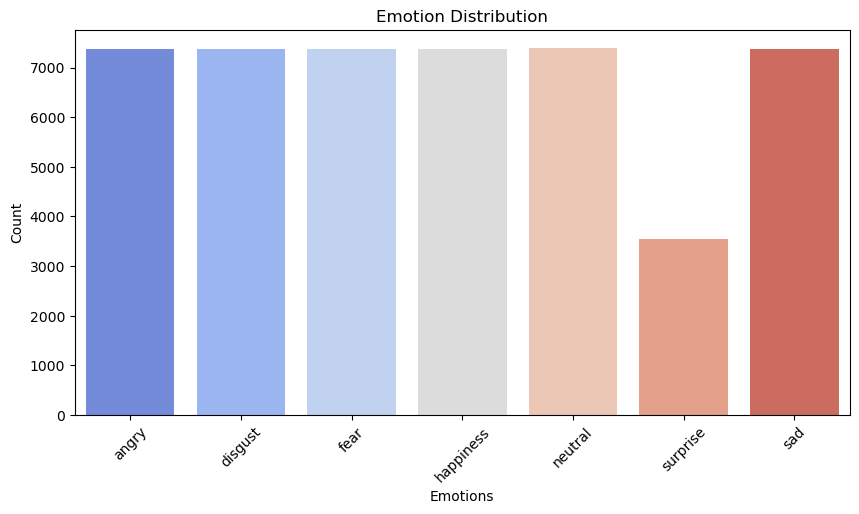

In [70]:
plt.figure(figsize=(10, 5))
sns.countplot(x="label", data=df, palette="coolwarm")

plt.xticks(rotation=45)
plt.title("Emotion Distribution")
plt.xlabel("Emotions")
plt.ylabel("Count")
plt.show()


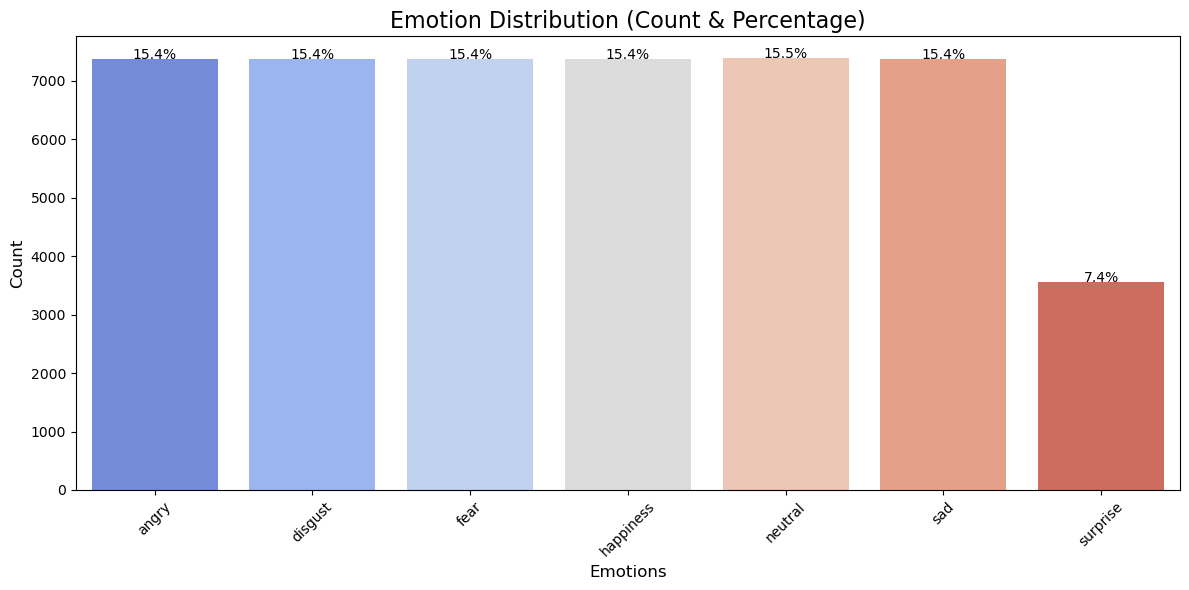

In [71]:
# Count values
emotion_counts = df['label'].value_counts().sort_index()
emotion_percent = (emotion_counts / len(df)) * 100

# Set up the figure
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='coolwarm')

# Annotate bars with percentage
for i, count in enumerate(emotion_counts.values):
    percent = emotion_percent.values[i]
    ax.text(i, count + 1, f'{percent:.1f}%', ha='center', fontsize=10, color='black')

# Add titles and labels
plt.title("Emotion Distribution (Count & Percentage)", fontsize=16)
plt.xlabel("Emotions", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


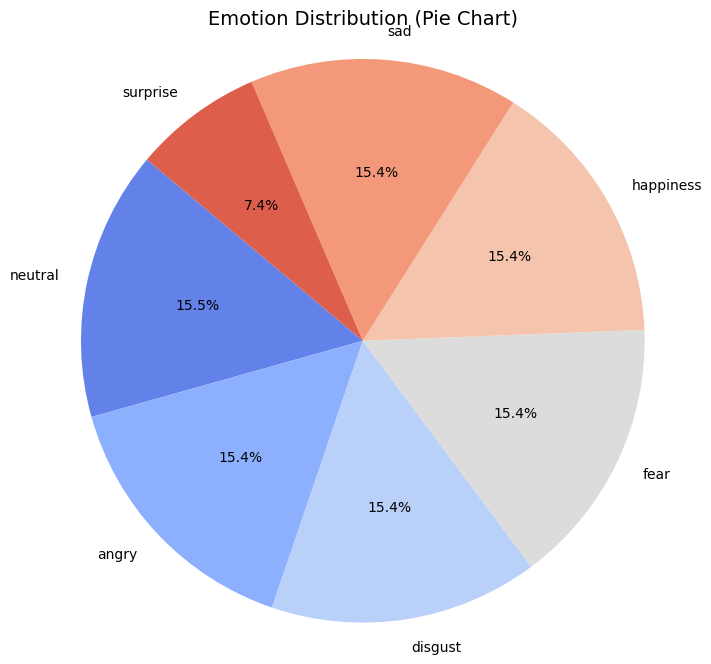

In [72]:
# Pie chart of emotion distribution
plt.figure(figsize=(8, 8))
emotion_counts = df['label'].value_counts()
plt.pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', 
        startangle=140, colors=sns.color_palette("coolwarm", len(emotion_counts)))
plt.title('Emotion Distribution (Pie Chart)', fontsize=14)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


In [7]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# Count missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]

# Only plot if there are missing values
if not missing_values.empty:
    plt.figure(figsize=(10, 5))
    sns.barplot(x=missing_values.index, y=missing_values.values, palette="Reds")
    plt.xticks(rotation=45)
    plt.title("Missing Values Per Column", fontsize=14)
    plt.ylabel("Number of Missing Values")
    plt.xlabel("Columns")
    plt.tight_layout()
    plt.show()
else:
    print("✅ No missing values found in the dataset.")


✅ No missing values found in the dataset.


In [15]:
import librosa
import numpy as np
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# 1. Augmentation functions
def add_noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    return data + noise_amp * np.random.normal(size=data.shape[0])

def time_stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def pitch_shift(data, sr, n_steps=0.7):
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=n_steps)

# 2. Feature extraction function
def extract_features(y, sr):
    features = []
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))
    features.append(zcr)

    stft = np.abs(librosa.stft(y))
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr))
    features.append(chroma)

    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40), axis=1)
    features.extend(mfcc)

    rms = np.mean(librosa.feature.rms(y=y))
    features.append(rms)

    mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128), axis=1)
    features.extend(mel)

    contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1)
    features.extend(contrast)

    return np.array(features)

# 3. Extract original + augmented features
def get_augmented_features(file_path):
    y, sr = librosa.load(file_path, duration=2.5, offset=0.6)
    features = []
    features.append(extract_features(y, sr))                         # Original
    features.append(extract_features(add_noise(y), sr))             # Noisy
    stretched = time_stretch(y)
    features.append(extract_features(pitch_shift(stretched, sr), sr))  # Time-stretch + Pitch
    return features

# 4. Build final feature set and save
def process_dataset(csv_path, output_csv="features_final.csv"):
    df = pd.read_csv(csv_path)
    X, Y = [], []

    for path, label in tqdm(zip(df["Path"], df["Emotion"]), total=len(df)):
        try:
            feats = get_augmented_features(path)
            for f in feats:
                X.append(f)
                Y.append(label)
        except Exception as e:
            print(f"❌ Skipped {path}: {e}")

    X = np.array(X)
    Y = np.array(Y)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    feature_df = pd.DataFrame(X_scaled)
    feature_df["label"] = Y
    feature_df.to_csv(output_csv, index=False)
    print(f"✅ Features saved to {output_csv}")

# 5. Call the function with your cleaned CSV
process_dataset("cleaned_speech_dataset.csv")


100%|████████████████████████████████████████████████████████████████████████████| 15921/15921 [54:05<00:00,  4.91it/s]


✅ Features saved to features_final.csv


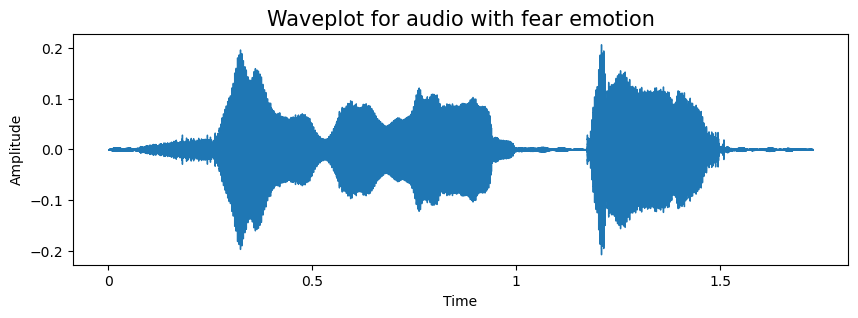

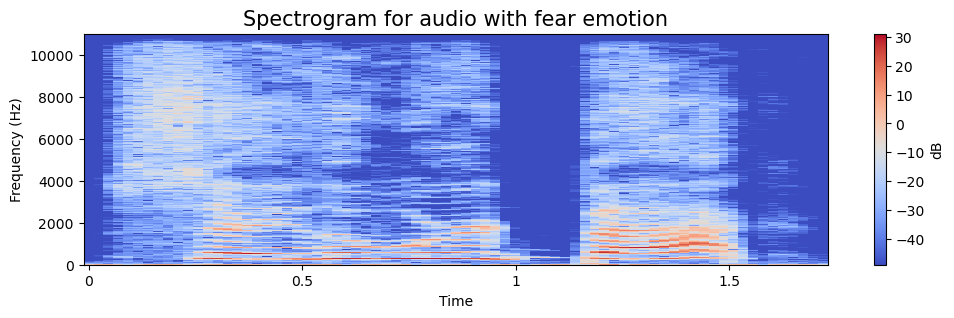

In [21]:
# Load the dataset
csv_path = r"C:\Users\ALL\combined_speech_dataset.csv"  # Path to your CSV
data_path = pd.read_csv(csv_path)

# Ensure "Path" and "Emotion" columns exist
if 'Path' not in data_path.columns or 'Emotion' not in data_path.columns:
    raise KeyError("Ensure 'Path' and 'Emotion' columns exist in the dataset.")

# Function to create waveplot
def create_waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {emotion} emotion', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

# Function to create spectrogram
def create_spectrogram(data, sr, emotion):
    X = librosa.stft(data)  # Short-Time Fourier Transform
    Xdb = librosa.amplitude_to_db(abs(X))  # Convert to dB
    plt.figure(figsize=(12, 3))
    plt.title(f'Spectrogram for audio with {emotion} emotion', size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(label="dB")
    plt.xlabel("Time")
    plt.ylabel("Frequency (Hz)")
    plt.show()

# Select an emotion to visualize
selected_emotion = "fear"  # Change this to any emotion (e.g., "happy", "sad", etc.)

# Check if the emotion exists in the dataset
if selected_emotion not in data_path['Emotion'].values:
    raise ValueError(f"No samples found for emotion '{selected_emotion}'. Available emotions: {data_path['Emotion'].unique()}")

# Extract file path for the first matching sample
audio_path = np.array(data_path.loc[data_path['Emotion'] == selected_emotion, 'Path'])[0]

# Load the audio file
audio_data, sampling_rate = librosa.load(audio_path)

# Generate waveplot and spectrogram
create_waveplot(audio_data, sampling_rate, selected_emotion)
create_spectrogram(audio_data, sampling_rate, selected_emotion)


In [22]:
# Load the dataset
csv_path = r"C:\Users\ALL\combined_speech_dataset.csv"  # Path to your CSV
data_path = pd.read_csv(csv_path)

# Ensure "Path" and "Emotion" columns exist
if 'Path' not in data_path.columns or 'Emotion' not in data_path.columns:
    raise KeyError("Ensure 'Path' and 'Emotion' columns exist in the dataset.")


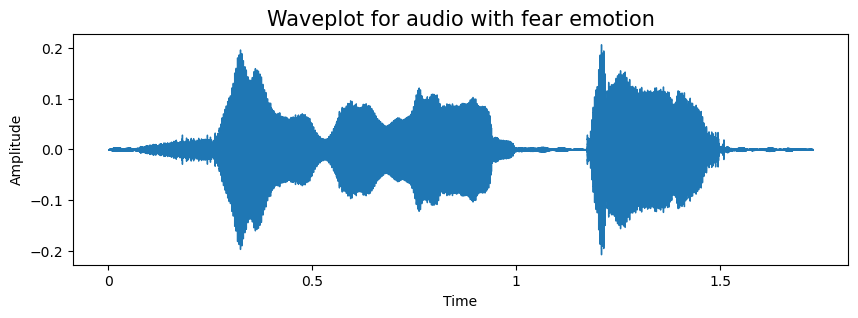

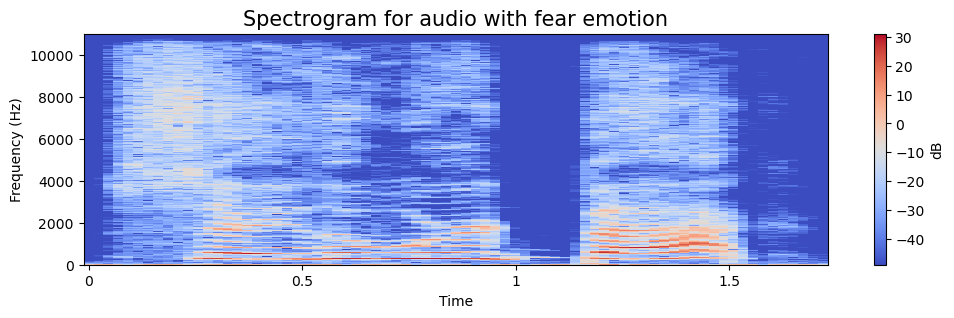

In [23]:
from IPython.display import Audio  # Import Audio for playing sound

emotion='fear'
path = np.array(data_path.Path[data_path.Emotion==emotion])[0]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

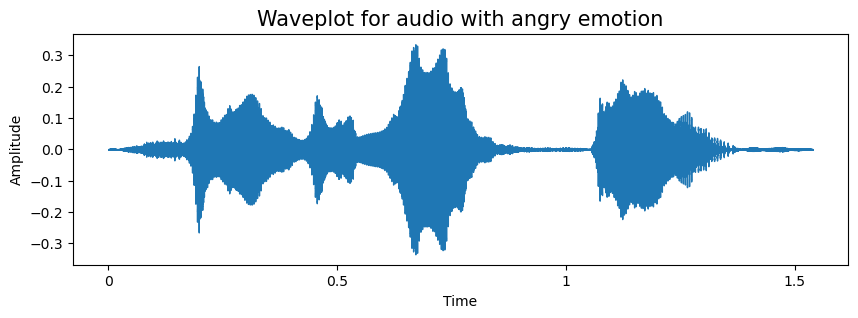

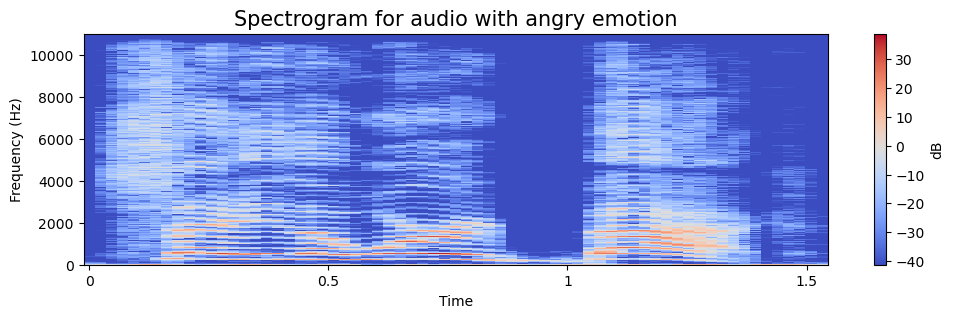

In [24]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotion==emotion])[0]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

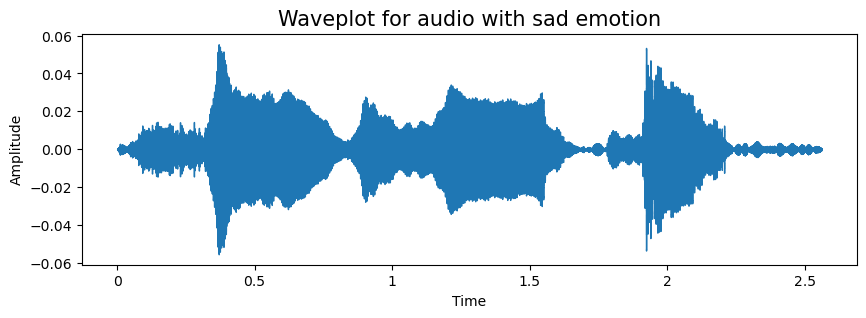

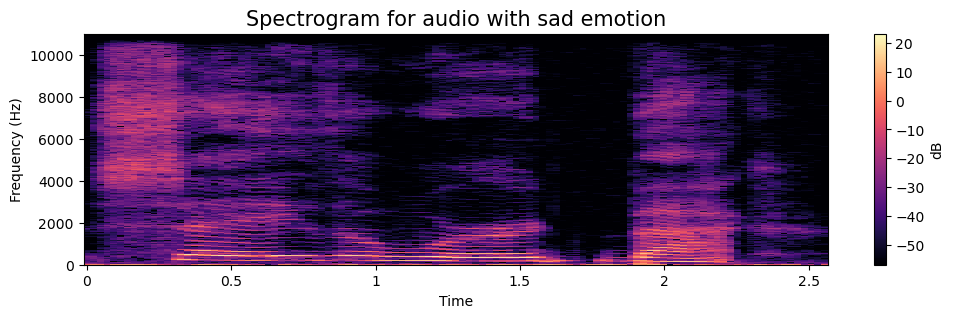

In [25]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotion==emotion])[0]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

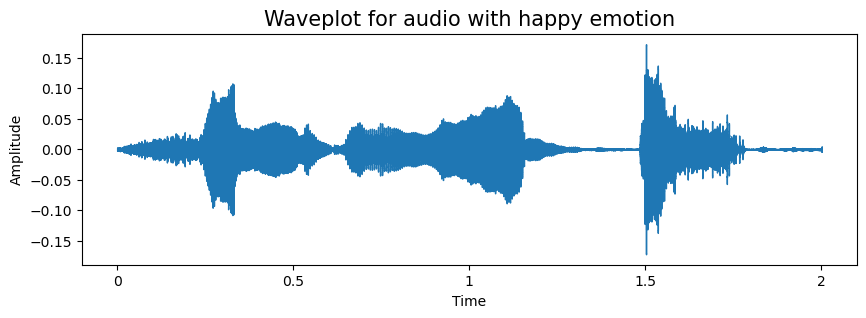

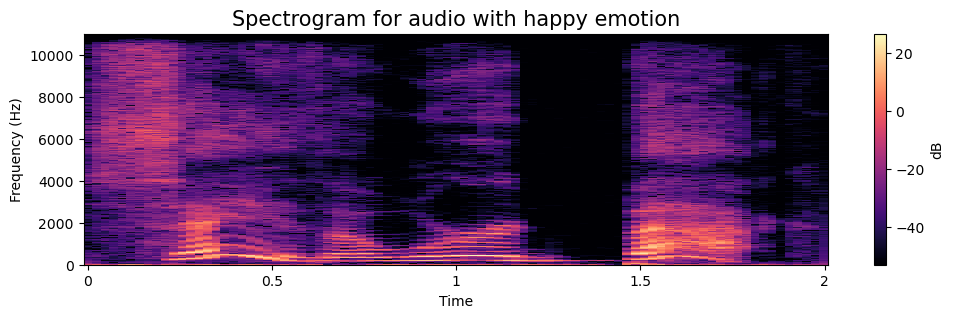

In [26]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotion==emotion])[0]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [8]:
# Count missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]

# Only plot if there are missing values
if not missing_values.empty:
    plt.figure(figsize=(10, 5))
    sns.barplot(x=missing_values.index, y=missing_values.values, palette="Reds")
    plt.xticks(rotation=45)
    plt.title("Missing Values Per Column", fontsize=14)
    plt.ylabel("Number of Missing Values")
    plt.xlabel("Columns")
    plt.tight_layout()
    plt.show()
else:
    print(" No missing values found in the dataset.")


 No missing values found in the dataset.


In [10]:
# Check for duplicates
duplicates = df.duplicated()
print(f" Number of duplicate rows: {duplicates.sum()}")

# Remove duplicates if any
if duplicates.any():
    df = df.drop_duplicates()
    print(" Duplicates removed.")
else:
    print(" No duplicate rows found.")


 Number of duplicate rows: 0
 No duplicate rows found.


In [13]:
from scipy.stats import zscore
#import pandas as pd
#import numpy as np

# Filter numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Calculate Z-scores
z_scores = np.abs(zscore(numeric_df, nan_policy='omit'))  # 'omit' avoids issues with NaNs

# Count outliers per column (values with Z > 3)
outliers_per_column = (z_scores > 3).sum(axis=0)

# Display
print(" Outliers detected per column:")
for col, count in zip(numeric_df.columns, outliers_per_column):
    print(f"{col}: {count}")


 Outliers detected per column:


In [20]:
# Load the DataFrame
df = pd.read_csv("features_final.csv")

# See all column names clearly
print("🧩 Column names:", df.columns.tolist())

# Check if 'label' exists and clean column names just in case
df.columns = df.columns.str.strip()  # Remove leading/trailing spaces

# Confirm again
print("✅ Cleaned Column names:", df.columns.tolist())

# Check if 'label' is now accessible
if 'label' in df.columns:
    label_counts = df['label'].value_counts()
    label_percent = df['label'].value_counts(normalize=True) * 100

    print("\n🎯 Label Counts:\n", label_counts)
    print("\n📊 Label Percentages:\n", label_percent)
else:
    print("🚫 'label' column not found even after cleaning.")


🧩 Column names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '

In [23]:
# Map similar emotions to unified categories
emotion_map = {
    'fearful': 'fear',
    'ps': 'fear',               # if 'ps' is another version of fear
    'calm': 'neutral',
    'surprised': 'surprise'
}

# Apply the mapping
df['label'] = df['label'].replace(emotion_map)

# Double-check unique emotions after merge
print(" Unique labels after cleaning:", df['label'].unique())

# Save cleaned version (optional)
df.to_csv("features_final_cleaned.csv", index=False)


 Unique labels after cleaning: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [22]:
label_counts = df['label'].value_counts()
label_percent = df['label'].value_counts(normalize=True) * 100

print("\n Cleaned Label Counts:\n", label_counts)
print("\n Cleaned Label Percentages:\n", label_percent)



 Cleaned Label Counts:
 label
fear        9765
neutral     7389
angry       7365
disgust     7365
happy       7365
sad         7365
surprise    1149
Name: count, dtype: int64

 Cleaned Label Percentages:
 label
fear        20.444696
neutral     15.470134
angry       15.419886
disgust     15.419886
happy       15.419886
sad         15.419886
surprise     2.405628
Name: proportion, dtype: float64


In [25]:
#import numpy as np

# Drop label column before computing correlation
X = df.drop('label', axis=1)

# Compute correlation matrix
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix (excluding diagonal)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(f" Highly correlated features to drop ({len(to_drop)}):\n", to_drop)

# Drop those features
df_reduced = df.drop(to_drop, axis=1)
print(f"\n New shape after dropping redundant features: {df_reduced.shape}")


 Highly correlated features to drop (13):
 ['151', '154', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170']

 New shape after dropping redundant features: (47763, 166)


In [26]:
# Original feature count (excluding label)
original_feature_count = df.shape[1] - 1

# Reduced feature count (excluding label)
reduced_feature_count = df_reduced.shape[1] - 1

print(f" Original number of features: {original_feature_count}")
print(f" Number of features after dropping: {reduced_feature_count}")
print(f" Number of features removed: {original_feature_count - reduced_feature_count}")


 Original number of features: 178
 Number of features after dropping: 165
 Number of features removed: 13


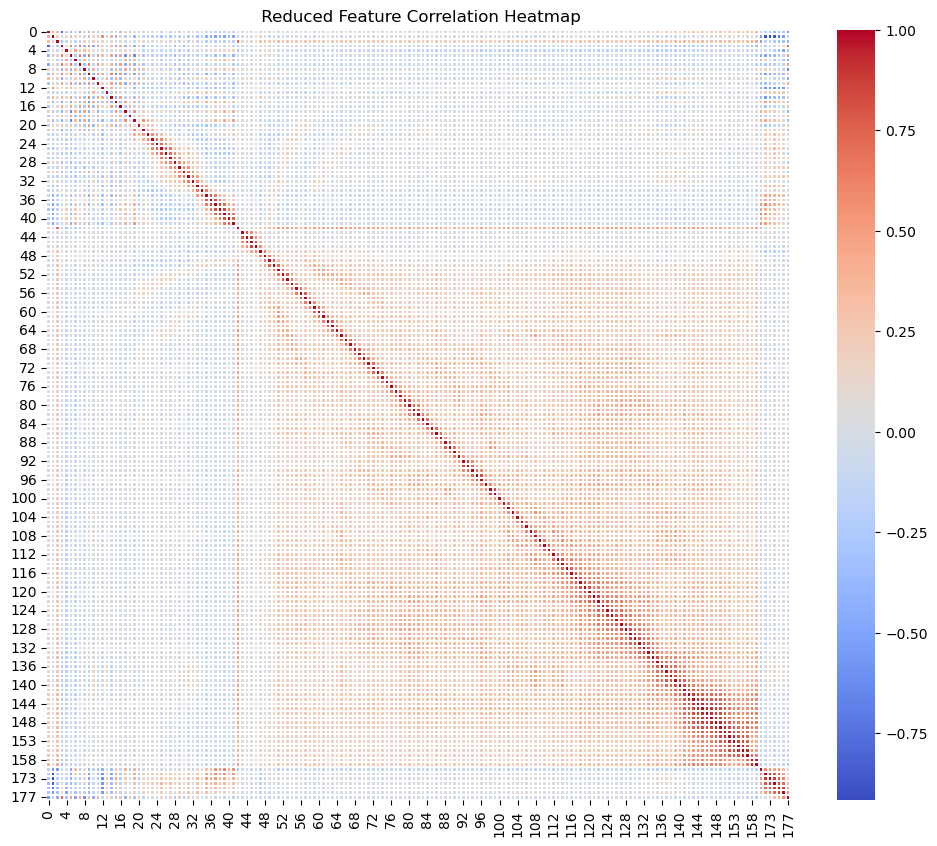

 Saved cleaned dataset as 'features_reduced.csv'


In [27]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_reduced.drop("label", axis=1).corr(), cmap="coolwarm", linewidths=0.1)
plt.title(" Reduced Feature Correlation Heatmap")
plt.show()
df_reduced.to_csv("features_reduced.csv", index=False)
print(" Saved cleaned dataset as 'features_reduced.csv'")


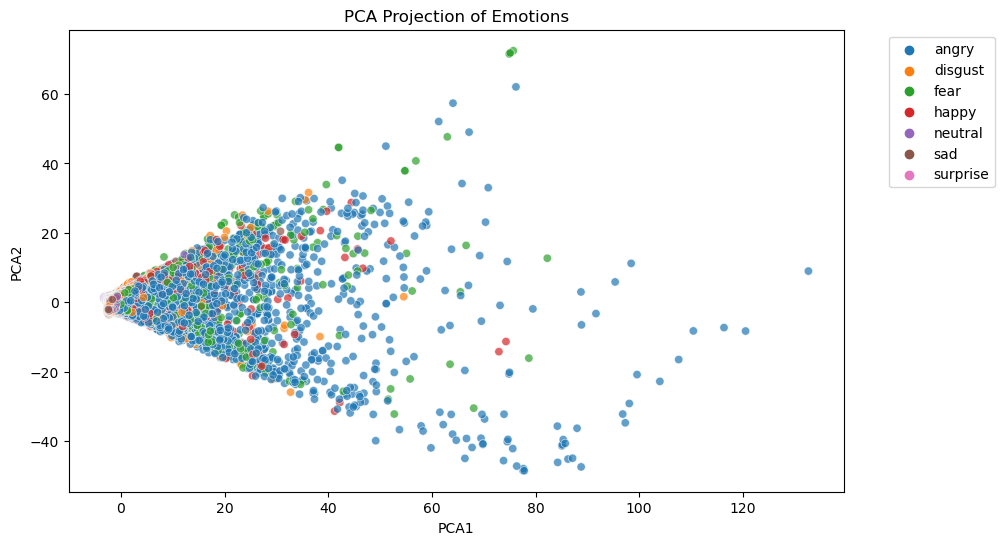

In [28]:
from sklearn.decomposition import PCA

# Reduce to 2 dimensions
X = df.drop("label", axis=1)
y = df["label"]
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a new DataFrame for plotting
pca_df = pd.DataFrame()
pca_df['PCA1'] = X_pca[:, 0]
pca_df['PCA2'] = X_pca[:, 1]
pca_df['Emotion'] = y

# Scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x="PCA1", y="PCA2", hue="Emotion", palette="tab10", alpha=0.7)
plt.title("PCA Projection of Emotions")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()


In [29]:
# Optional: Rename numeric columns
new_columns = [f"feature_{i}" for i in range(df.shape[1]-1)] + ["label"]
df.columns = new_columns

print(df.columns)


Index(['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       ...
       'feature_169', 'feature_170', 'feature_171', 'feature_172',
       'feature_173', 'feature_174', 'feature_175', 'feature_176',
       'feature_177', 'label'],
      dtype='object', length=179)


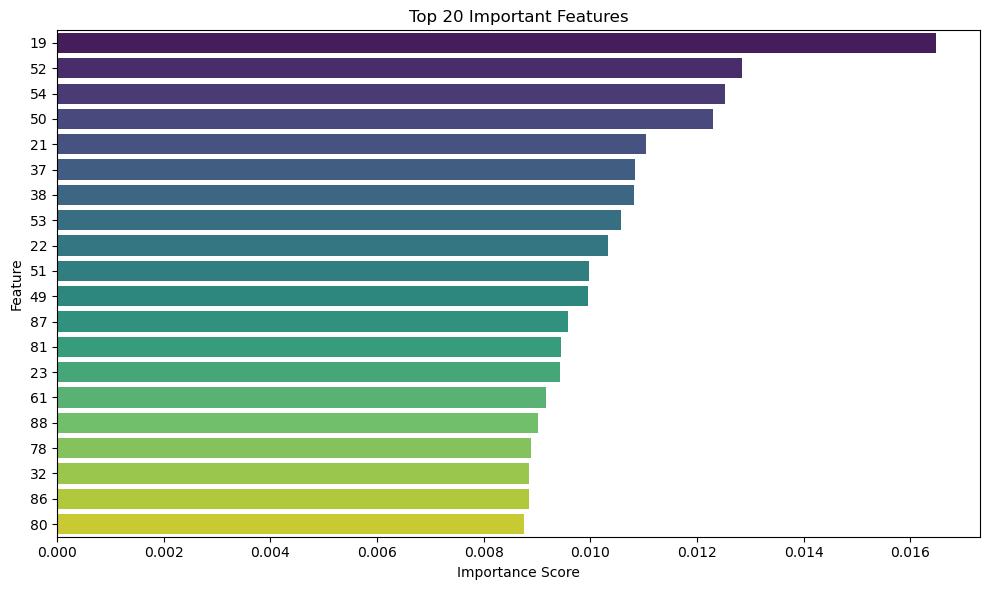

In [31]:
from sklearn.ensemble import RandomForestClassifier

# Train a simple Random Forest for feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get importance
importances = rf.feature_importances_
indices = np.argsort(importances)[-20:][::-1]  # Top 20

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=[X.columns[i] for i in indices], palette="viridis")
plt.title("Top 20 Important Features")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## Data Augmentation

- Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
- To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
- The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
- In order to this to work adding the perturbations must conserve the same label as the original training sample.
- In images data augmention can be performed by shifting the image, zooming, rotating ...

First, let's check which augmentation techniques works better for our dataset.

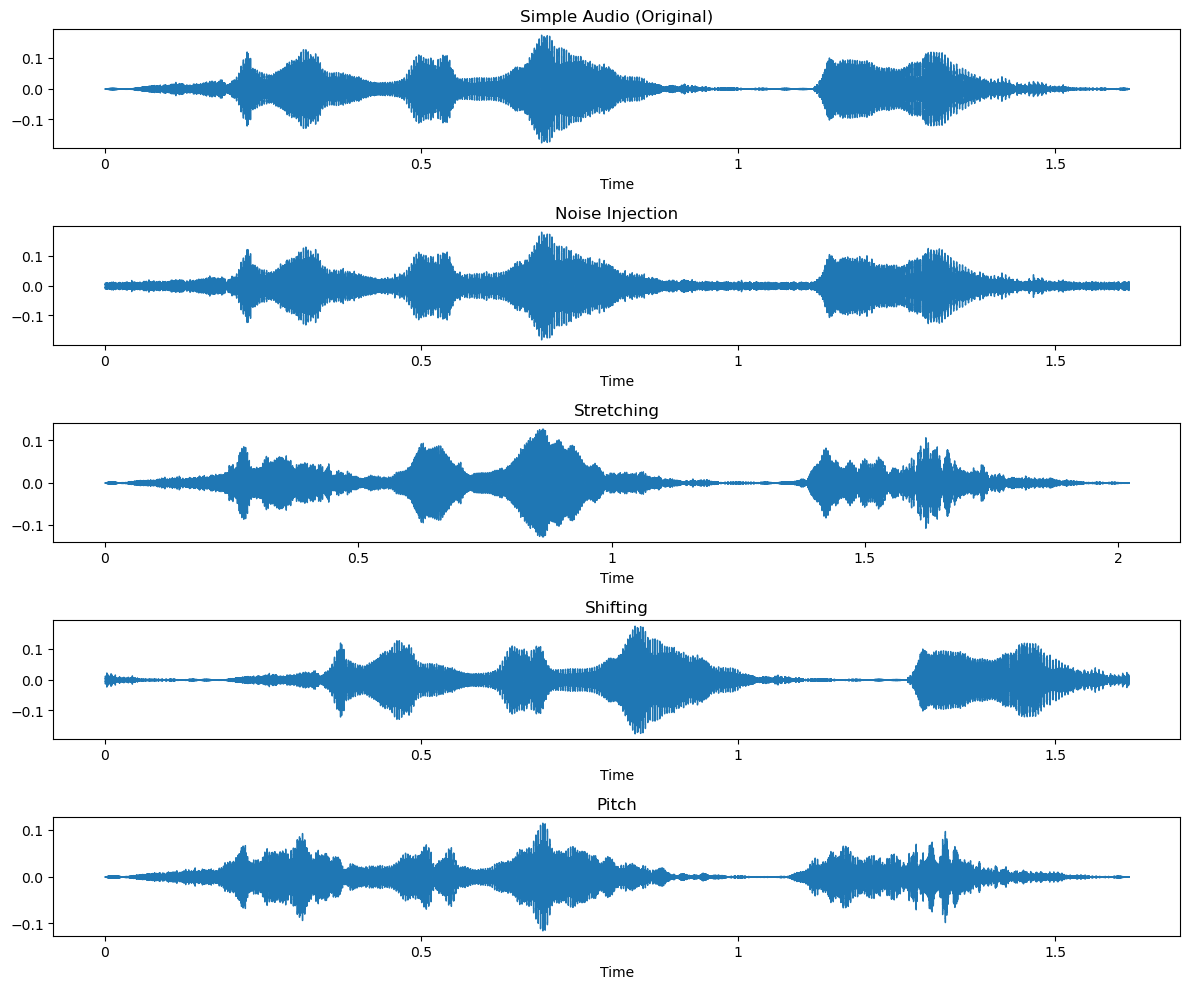

In [27]:
# Data augmentation functions
def noise_injection(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    return data + noise_amp * np.random.normal(size=data.shape[0])

def stretching(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shifting(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch_change(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# Select an example file
path = np.array(data_path['Path'])[1]  # ✅ Fixed column access

# Load the audio file
data, sample_rate = librosa.load(path)

# Apply augmentation techniques
data_noise = noise_injection(data)
data_stretch = stretching(data)
data_shift = shifting(data)
data_pitch = pitch_change(data, sample_rate)

# Plot the waveforms
plt.figure(figsize=(12, 10))

plt.subplot(5, 1, 1)
librosa.display.waveshow(data, sr=sample_rate)
plt.title("Simple Audio (Original)")

plt.subplot(5, 1, 2)
librosa.display.waveshow(data_noise, sr=sample_rate)
plt.title("Noise Injection")

plt.subplot(5, 1, 3)
librosa.display.waveshow(data_stretch, sr=sample_rate)
plt.title("Stretching")

plt.subplot(5, 1, 4)
librosa.display.waveshow(data_shift, sr=sample_rate)
plt.title("Shifting")

plt.subplot(5, 1, 5)
librosa.display.waveshow(data_pitch, sr=sample_rate)
plt.title("Pitch")

plt.tight_layout()
plt.show()


We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

- From the above types of augmentation techniques i am using noise, stretching(ie. changing speed) and some pitching.

# Data Preprocessing and Feature Extraction

### Objective:
To convert raw audio data from file paths into meaningful numerical features that can be used to train deep learning models for emotion recognition.



### Features Extracted:

- **Zero Crossing Rate (ZCR)** – Measures how often the signal crosses the zero axis.
- **Chroma STFT** – Represents energy distribution across 12 distinct pitch classes.
- **MFCC (Mel-Frequency Cepstral Coefficients)** – Captures timbral texture; we extract 40 coefficients.
- **Spectral Centroid** – Indicates the center of mass of the spectrum (perceived brightness).
- **Spectral Bandwidth** – Measures the spread of the spectrum.
- **Spectral Rolloff** – Represents the frequency below which 85% of the signal energy is contained.
- **Root Mean Square Energy (RMSE)** – Measures signal energy.



Each audio file is processed, and the extracted features are aggregated into a new DataFrame `features_df`, which will be used for model training in the next step.


In [51]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm

# Initialize empty list to store features
feature_list = []

# Loop through each file
for index, row in tqdm(df.iterrows(), total=len(df)):
    file_path = row['Path']
    emotion = row['Emotion']

    try:
        y, sr = librosa.load(file_path, sr=None)

        # Extract features
        zcr = np.mean(librosa.feature.zero_crossing_rate(y).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
        mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr).T, axis=0)
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr).T, axis=0)
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr).T, axis=0)
        rmse = np.mean(librosa.feature.rms(y=y).T, axis=0)

        # Concatenate all features
        features = np.hstack([
            zcr,
            chroma,
            mfcc,
            spectral_centroid,
            spectral_bandwidth,
            spectral_rolloff,
            rmse
        ])

        feature_list.append([*features, emotion])
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        continue

# Define feature column names
zcr_names = ['zcr']
chroma_names = [f'chroma_{i+1}' for i in range(12)]
mfcc_names = [f'mfcc_{i+1}' for i in range(40)]
spec_names = ['centroid', 'bandwidth', 'rolloff', 'rmse']
columns = zcr_names + chroma_names + mfcc_names + spec_names + ['emotion']

# Create DataFrame
features_df = pd.DataFrame(feature_list, columns=columns)

# Preview
features_df.head()


100%|████████████████████████████████████████████████████████████████████████████| 15921/15921 [16:17<00:00, 16.29it/s]


,zcr,chroma_1,chroma_2,chroma_3,chroma_4,chroma_5,chroma_6,chroma_7,chroma_8,chroma_9,...,mfcc_36,mfcc_37,mfcc_38,mfcc_39,mfcc_40,centroid,bandwidth,rolloff,rmse,emotion
0,0.081048,0.512385,0.266571,0.169456,0.206460,0.241793,0.227825,0.319404,0.329372,0.237085,...,3.624235,-3.197896,3.257797,7.468832,3.827291,2244.518922,2417.499675,4023.786502,0.041406,0
1,0.085180,0.568114,0.416963,0.241540,0.231176,0.316287,0.334227,0.236022,0.237972,0.214004,...,0.411314,-4.341255,1.958078,8.583110,3.625564,2182.569100,2405.502339,3817.591309,0.022364,0
2,0.127679,0.399493,0.501570,0.304703,0.232847,0.234854,0.258220,0.200182,0.185630,0.211558,...,-2.561713,0.864067,2.753765,6.778628,0.421136,2964.378675,2675.259261,5331.541280,0.029732,0
3,0.105919,0.456796,0.298421,0.186001,0.196697,0.232437,0.295681,0.320287,0.300685,0.296279,...,4.447577,-0.583004,4.037889,5.985087,5.131718,2636.422929,2515.913088,4431.942332,0.043054,0
4,0.076019,0.288210,0.482150,0.428019,0.321111,0.204955,0.197855,0.153549,0.127835,0.167513,...,0.220682,0.006068,2.763911,1.968200,-1.524306,2330.168832,2432.395141,4295.259839,0.030544,0


# Label Encoding, Feature Scaling & Train-Test Split

In [52]:
# --- Required Libraries ---
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.utils import to_categorical

# --- 1. Separate features (X) and target labels (y) ---
X = features_df.drop('emotion', axis=1)
y = features_df['emotion']

# --- 2. Scale Features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 3. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# --- 4. One-Hot Encode Target Labels ---
y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)

# --- 5. Output Summary ---
print(" X_train shape:", X_train.shape)
print(" X_test shape:", X_test.shape)
print(" y_train_ohe shape:", y_train_ohe.shape)
print(" y_test_ohe shape:", y_test_ohe.shape)


 X_train shape: (12736, 57)
 X_test shape: (3185, 57)
 y_train_ohe shape: (12736, 10)
 y_test_ohe shape: (3185, 10)


In [56]:
# 📦 Required Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical

# 🧾 Copy original data
df_processed = df.copy()

# 🔁 Label Encoding
label_encoder = LabelEncoder()
df_processed['emotion'] = label_encoder.fit_transform(df_processed['Emotion'])

# 🎯 Extract Features and Target
X = df_processed.drop(columns=['Dataset', 'File Name', 'Actor', 'Emotion', 'Path'])
y = df_processed['emotion']

# 📊 Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🔀 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# 🔢 One-Hot Encoding the target labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# 🔍 Print for verification
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (12736, 1)
y_train shape: (12736, 10)
X_test shape: (3185, 1)
y_test shape: (3185, 10)


### Summary of Actions:
- Separated the dataset into **input features (`X`)** and **target labels (`y`)**
- Applied **feature scaling** using `StandardScaler` to normalize input values and improve model convergence
- Performed an **80-20 train-test split**, ensuring class balance with stratification
- Applied **one-hot encoding** to the target labels to enable multi-class classification

 The preprocessed dataset is now ready for training deep learning models such as **MLP**, **CNN**, and **LSTM** in the upcoming steps.


# Building and Training the MLP Model

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# MLP Model Architecture
model = Sequential()
model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer

#  Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

#  Callbacks for early stopping and LR reduction
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

#  Model Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

#  Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Accuracy: {test_acc:.4f}")


Epoch 1/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4193 - loss: 1.5914 - val_accuracy: 0.9014 - val_loss: 0.2841 - learning_rate: 0.0010
Epoch 2/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8677 - loss: 0.3966 - val_accuracy: 0.9758 - val_loss: 0.1094 - learning_rate: 0.0010
Epoch 3/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9256 - loss: 0.2115 - val_accuracy: 0.9758 - val_loss: 0.0528 - learning_rate: 0.0010
Epoch 4/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9471 - loss: 0.1499 - val_accuracy: 1.0000 - val_loss: 0.0254 - learning_rate: 0.0010
Epoch 5/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9704 - loss: 0.1003 - val_accuracy: 1.0000 - val_loss: 0.0111 - learning_rate: 0.0010
Epoch 6/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9777 - loss: 0.0707 - val_accuracy: 1.0000 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 7/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9802 - loss: 0.

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
📊 Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       491
           1       1.00      1.00      1.00        77
           2       1.00      1.00      1.00       491
           3       1.00      1.00      1.00       160
           4       1.00      1.00      1.00       331
           5       1.00      1.00      1.00       491
           6       1.00      1.00      1.00       416
           7       1.00      1.00      1.00       160
           8       1.00      1.00      1.00       491
           9       1.00      1.00      1.00        77

    accuracy                           1.00      3185
   macro avg       1.00      1.00      1.00      3185
weighted avg       1.00      1.00      1.00      3185



<Figure size 1000x800 with 0 Axes>

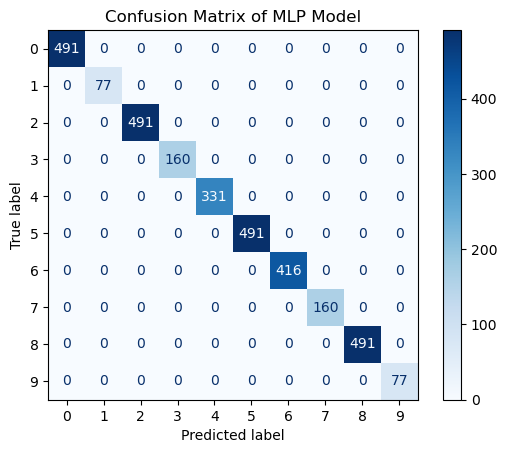

In [61]:
# Predict on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Fix: Convert label classes to strings
target_names = label_encoder.classes_.astype(str)

# Classification report
print("📊 Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=target_names))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=target_names)
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix of MLP Model")
plt.show()


# Feature Extraction for CNN and LSTM

In [4]:
from tqdm import tqdm

# Path to your combined speech dataset CSV
csv_path = r"C:\Users\ALL\combined_speech_dataset.csv"

# Load the CSV
df = pd.read_csv(csv_path)

# Define parameters for mel-spectrogram
SAMPLE_RATE = 22050
DURATION = 3  # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
N_MELS = 128

# Features list
features = []

# Feature extraction loop
print("Extracting features from audio files...\n")
for index, row in tqdm(df.iterrows(), total=len(df)):
    file_path = row["Path"]
    emotion = row["Emotion"]

    try:
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION, res_type='kaiser_fast')

        # Padding/trimming to fixed length
        if len(y) < SAMPLES_PER_TRACK:
            y = np.pad(y, (0, SAMPLES_PER_TRACK - len(y)))
        else:
            y = y[:SAMPLES_PER_TRACK]

        # Extract mel-spectrogram
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
        mel_db = librosa.power_to_db(mel, ref=np.max)

        # Normalize
        mel_db = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min())

        # Store
        features.append([mel_db, emotion])

    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Convert to arrays
X = np.array([f[0] for f in features])
y = np.array([f[1] for f in features])

# Reshape for CNN and LSTM
X_cnn = X[..., np.newaxis]  # (samples, n_mels, time, 1)
X_lstm = X.transpose((0, 2, 1))  # (samples, time, n_mels)

# Save the arrays for reuse
np.save("X_cnn.npy", X_cnn)
np.save("X_lstm.npy", X_lstm)
np.save("y.npy", y)

print("\n✅ Feature extraction completed successfully.")
print(f"Shape of X_cnn: {X_cnn.shape}")
print(f"Shape of X_lstm: {X_lstm.shape}")
print(f"Shape of y: {y.shape}")


Extracting features from audio files...



100%|████████████████████████████████████████████████████████████████████████████| 15921/15921 [09:47<00:00, 27.12it/s]



✅ Feature extraction completed successfully.
Shape of X_cnn: (15921, 128, 130, 1)
Shape of X_lstm: (15921, 130, 128)
Shape of y: (15921,)


# Convolutional Neural Network (CNN) Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y, test_size=0.2, random_state=42, stratify=y)

# Encode the labels
le = LabelEncoder()
y_train_encoded = to_categorical(le.fit_transform(y_train))
y_test_encoded = to_categorical(le.transform(y_test))

# Confirm number of classes
num_classes = y_train_encoded.shape[1]

# Build the CNN model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=X_cnn.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train, y_train_encoded,
    validation_data=(X_test, y_test_encoded),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, lr_reduce],
    verbose=1
)


Epoch 1/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 701s 2s/step - accuracy: 0.2620 - loss: 4.0639 - val_accuracy: 0.1199 - val_loss: 18.7719 - learning_rate: 0.0010
Epoch 2/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 703s 2s/step - accuracy: 0.3622 - loss: 1.6131 - val_accuracy: 0.4967 - val_loss: 1.3450 - learning_rate: 0.0010
Epoch 3/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 687s 2s/step - accuracy: 0.4334 - loss: 1.4071 - val_accuracy: 0.5155 - val_loss: 1.1912 - learning_rate: 0.0010
Epoch 4/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 685s 2s/step - accuracy: 0.4602 - loss: 1.3369 - val_accuracy: 0.5473 - val_loss: 1.1693 - learning_rate: 0.0010
Epoch 5/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 703s 2s/step - accuracy: 0.4738 - loss: 1.3027 - val_accuracy: 0.5391 - val_loss: 1.1347 - learning_rate: 0.0010
Epoch 6/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 3599s 9s/step - accuracy: 0.4858 - loss: 1.2636 - val_accuracy: 0.5535 - val_loss: 1.1201 - learning_rate: 0.0010
Epoch 7/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 704s 2s/step - accuracy: 0.5008 -